
--- LOAD FILE 'ảnh xx3.jpg' VÀ 'ảnh xx.jpg' ---
Kích thước xử lý: Trái (645, 278, 3), Phải (651, 302, 3)
=== BẮT ĐẦU QUY TRÌNH ===

1. Tìm Keypoints & Descriptor (Thủ công)...
   -> Ảnh Trái: 173 KP
   -> Ảnh Phải: 161 KP


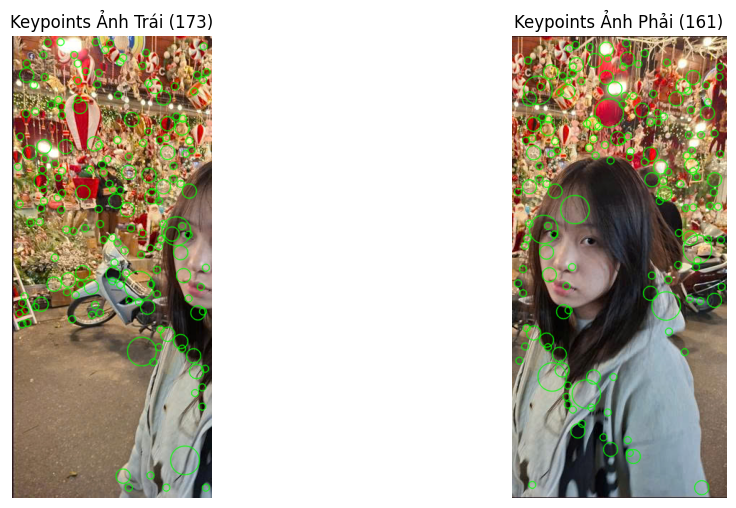


2. Matching Keypoints...
   -> Tìm thấy 68 cặp điểm.


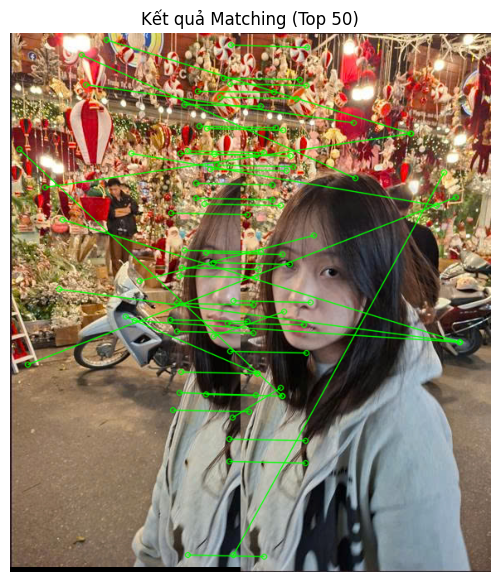


3. RANSAC Tìm Homography...

4. Warping Ảnh Phải theo Ma trận H...
   -> Kích thước canvas sau khi Warp: (np.int32(488), np.int32(651))


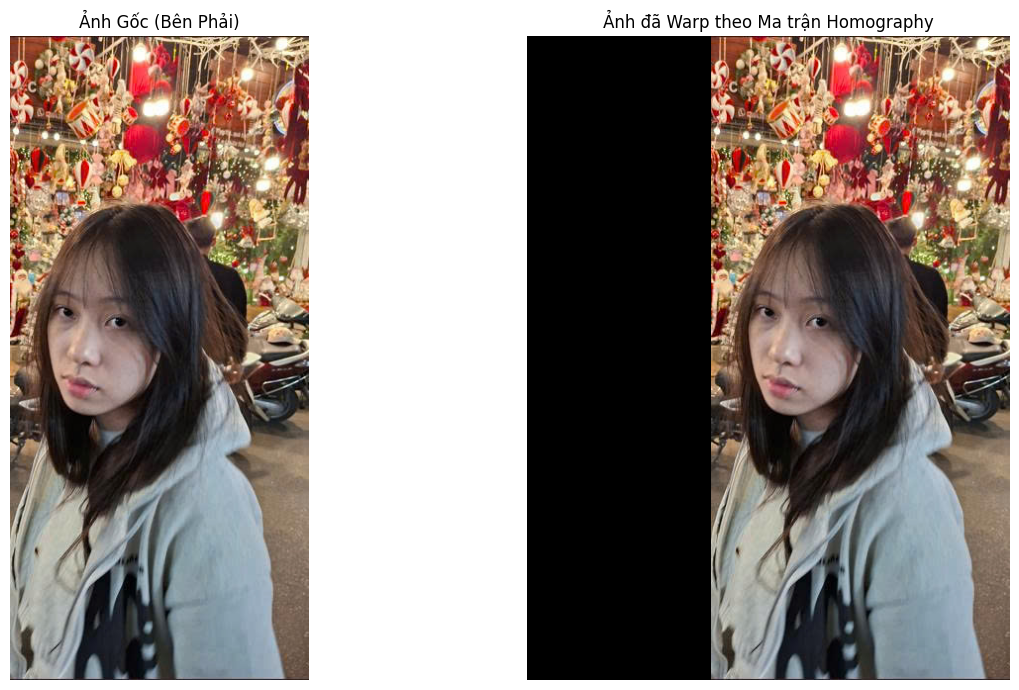

   -> Đã lưu 'anh_da_warp.jpg'

5. Ghép và Trộn (Blending)...


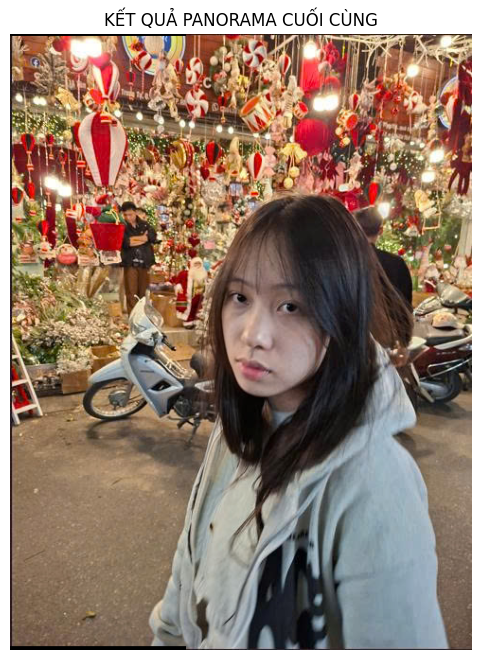

Đã xong! Kết quả lưu tại 'kq_final_panorama.jpg'


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import os

# ==============================================================================
# CẤU HÌNH CHẠY
# ==============================================================================
RUN_MODE = 2  # 1: Tự tạo ảnh test, 2: Load 2 file ảnh thật
IMG_LEFT  = 'ảnh xx3.jpg'   # Ảnh gốc (bên trái - đích)
IMG_RIGHT = 'ảnh xx.jpg'  # Ảnh cần ghép (bên phải - nguồn)

# ==============================================================================
# 1. CLASS MySIFT
# ==============================================================================
class MySIFT:
    def __init__(self, num_octaves=3, s=2, sigma=1.6, contrast_threshold=0.04, edge_threshold=10):
        self.num_octaves = num_octaves
        self.s = s
        self.sigma = sigma
        self.contrast_threshold = contrast_threshold
        self.edge_threshold = edge_threshold

# Hàm này sinh ra một ma trận số (kernel) đặc biệt. Khi bạn lấy ma trận này "quét" (tích chập) qua bức ảnh gốc, nó sẽ làm nhòe bức ảnh đi đúng theo mức độ sigma mong muốn, giúp tạo ra các tầng trong Tháp Gaussian (Gaussian Pyramid) để SIFT tìm kiếm đặc trưng.
# sigma càng lớn thì ảnh càng mờ
    def create_gaussian_kernel(self, sigma):
      # 3* sigma là bán kính cần thiết
      # size là size của ma trận
        size = int(2 * np.ceil(3 * sigma) + 1)
        # tạo ra các tọa độ x, y cho ma trận
        x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
        # giá trị độ mờ tại tọa độ x, y
        g = np.exp(-(x**2 + y**2) / (2 * sigma**2))
        return g / g.sum()

    def generate_gaussian_images(self, image):
      gaussian_images = []
      # Tính hệ số k: k là bước nhảy của độ mờ giữa các tầng kề nhau trong một octave
      # s là số khoảng (intervals) muốn chia trong mỗi octave
      k = 2 ** (1 / self.s)

      octaves = []
      img = image.copy()

      # --- PHẦN 1: TẠO ẢNH GỐC CHO MỖI OCTAVE (TẦNG CƠ SỞ) ---
      for _ in range(self.num_octaves):
          octaves.append(img)
          # Thu nhỏ ảnh đi một nửa (Subsampling) cho octave tiếp theo
          # img[::2, ::2] nghĩa là lấy các pixel ở hàng chẵn, cột chẵn
          img = img[::2, ::2]

      # --- PHẦN 2: TẠO CÁC ẢNH MỜ TRONG TỪNG OCTAVE ---
      for base_img in octaves:
          octave_imgs = [base_img] # Bắt đầu với ảnh gốc của octave đó
          current_sigma = self.sigma # Độ mờ ban đầu

          # Tạo thêm s+2 ảnh mờ nữa (tổng s+3 ảnh cho mỗi octave)
          for i in range(self.s + 2):
              # Tính sigma mới: tăng dần theo lũy thừa của k
              kernel_sigma = current_sigma * (k**(i+1))

              # Tạo bộ lọc (kính mờ) với độ mạnh kernel_sigma
              kernel = self.create_gaussian_kernel(kernel_sigma)

              # Áp dụng bộ lọc lên ảnh gốc (base_img) để tạo ảnh mờ (blurred)
              blurred = cv2.filter2D(base_img, -1, kernel)

              # Lưu ảnh mờ vào danh sách
              octave_imgs.append(blurred)

          # Lưu toàn bộ chồng ảnh mờ của octave này vào danh sách tổng
          gaussian_images.append(octave_imgs)

      return gaussian_images

      # tạo ảnh hiệu DoG
    def generate_dog_images(self, gaussian_images):
      # khởi tạo danh sách chứa tất cả các ảnh DoG của tất cả quãng 8
        dog_images = []
        # duyệt qua từng quãng 8
        for octave in gaussian_images:
          # DoG của chỉ quãng 8 đang xét
            dog_octave = []
            for i in range(len(octave) - 1):
              # ảnh mờ trước trừ ảnh mờ hiện tại
                dog = octave[i+1].astype('float32') - octave[i].astype('float32')
                dog_octave.append(dog)
            dog_images.append(dog_octave)
        return dog_images

# tính toán hướng cho ô 4x4
# mag độ lớn gradient
# ang hướng gradient
    def calculate_orientation_hist(self, mag, ang, w, d=4, n=8):
      # tạo mảng chứa n phần tử với giá trị khởi tạo là 0
        hist = np.zeros(n)
        # mỗi thùng chứa khoảng giá trị bao nhiêu: từ 0 đến 45 độ ,...
        bin_width = 360.0 / n
        rows, cols = mag.shape
        # duyệt qua từng pixel
        for i in range(rows):
            for j in range(cols):
              # hướng gradient của pixel hiện tại
                angle = ang[i, j]
                # sức nặng của lá phiếu = độ lớn gradient nhân với trọng số gauss w tại i,j đó
                weight = mag[i, j] * w[i, j]
                # xác định xem hướng này thuộc thùng nào
                # góc 40 độ sẽ thuộc thùng 0 (0-45 độ), góc 50 độ thuộc thùng 1.
                # Phép chia lấy nguyên // giúp tìm chỉ số thùng,
                # và phép chia lấy dư % n đảm bảo chỉ số luôn nằm trong khoảng 0 đến n-1.
                bin_idx = int(angle // bin_width) % n
                hist[bin_idx] += weight
        return hist

# tìm cực trị địa phương: mục đích để tìm các ứng cử viên có thể trở thành keypoint
    def find_extrema(self, dog_images):
        keypoints = []
        # duyệt qua không gian tỷ lệ với 3 for
        # vòng đầu tiên: duyệt qua tất cả các quãng 8
        for oct_idx, dog_octave in enumerate(dog_images):
          # vòng thứ hai: duyệt qua tất cả các ảnh DoG
          # tại sao lại xét từ 1 đến len(dog_octave) - 1? vì bỏ qua ảnh DoG đầu và cuối để đối sánh
            for img_idx in range(1, len(dog_octave) - 1):
                img_prev = dog_octave[img_idx - 1]
                img_curr = dog_octave[img_idx]
                img_next = dog_octave[img_idx + 1]
                rows, cols = img_curr.shape
                # vòng thứ 3: duyệt qua tất cả các điểm ảnh
                # bỏ đi các pixel viền vì không đủ 8 pixel xung quanh để so sánh
                for r in range(1, rows - 1):
                    for c in range(1, cols - 1):
                      # lọc điểm tương phản thấp: dùng để loại bỏ nhiễu. Làm đầu vào ít đi khi đến bước so sánh để tìm cực trị
                        val = img_curr[r, c]
                        if abs(val) < self.contrast_threshold * 255: continue
                        # so sánh với 26 pixel lân cận để tìm cực trị
                        # kiểm tra xem pixel hiện tại có phải điểm lớn nhất/ nhỏ nhất khi so với 26 pixel kia không
                        # nếu là cực trị -> nó là 1 ứng cử viên cho keypoint
                        # cho hết 26 ứng cử viên vào 1 stack để xét
                        block = np.stack([
                            img_prev[r-1:r+2, c-1:c+2],
                            img_curr[r-1:r+2, c-1:c+2],
                            img_next[r-1:r+2, c-1:c+2]
                        ])
                        center_pixel = block[1, 1, 1]
                        if center_pixel > 0:
                          # tạm thời cho là âm vô cùng để không ảnh hưởng đến việc tìm max với hàng xóm. cho xong nó vẫn nằm trong stack ý
                            block[1, 1, 1] = -np.inf
                            # nếu không thỏa mãn điều kiện lớn nhất thì bỏ
                            if center_pixel < np.max(block): continue
                        else:
                            block[1, 1, 1] = np.inf
                            # nếu không thỏa mãn điều kiện nhỏ nhất thì bỏ
                            if center_pixel > np.min(block): continue

                      # chỉ giữ lại các keypoint nằm ở góc (thay đổi ở mọi hướng), còn ở cạnh(1 hướng tăng mạnh, 1 hướng ít thay đổi) thì bỏ đi vì khó là điểm duy nhất
                        Dxx = img_curr[r, c+1] + img_curr[r, c-1] - 2*val
                        Dyy = img_curr[r+1, c] + img_curr[r-1, c] - 2*val
                        Dxy = (img_curr[r+1, c+1] - img_curr[r+1, c-1] - img_curr[r-1, c+1] + img_curr[r-1, c-1]) / 4.0
                        trace = Dxx + Dyy
                        det = Dxx * Dyy - Dxy**2
                        if det <= 0: continue
                        # công thức giúp đo độ cong của bề mặt ảnh tại điểm đó để phân biệt đâu là Góc, đâu là Cạnh.
                        score = (trace**2) / det
                        threshold_score = ((self.edge_threshold + 1)**2) / self.edge_threshold
                        if score >= threshold_score: continue


                        # Lưu kết quả keypoint chính thức
                        scale_mult = 2 ** oct_idx
                        kp = cv2.KeyPoint(float(c * scale_mult), float(r * scale_mult), size=10 * scale_mult)
                        kp.octave = oct_idx
                        kp.class_id = img_idx
                        keypoints.append(kp)
        return keypoints

# tính toán descriptor. Đây là mô tả cho keypoint bằng 1 vector 128 chiều. Nó bất biến với độ sáng, xoay và đầy đủ đặc trưng
    def compute_descriptors(self, gaussian_images, keypoints):
        descriptors = []
        valid_keypoints = []
        # chọn 1 vùng 16x16 xung quanh keypoint. Chia vùng đó thành 16 vùng 4x4
        # d=4 (ô con 4x4), n=8 (số hướng 360/8...), width=4 (số lượng ô con theo hàng + theo cột) -> 16 ô con 4x4 x 8 hướng mỗi ô con = 128
        d, n, width = 4, 8, 4
        # tạo 1 mặt nạ gauss(hình quả chuông) để cho các pixel nào càng gần tâm thì càng quan trọng
        gauss_weight = self.create_gaussian_kernel(sigma=8)
        gauss_weight = cv2.resize(gauss_weight, (16, 16))

        # duyệt qua từng keypoint
        for kp in keypoints:
          # lấy thông tin về octave, scale, tọa độ từ keypoint vừa được lấy
            octave_idx = kp.octave
            scale_idx = kp.class_id
            if scale_idx >= len(gaussian_images[octave_idx]): continue
            img = gaussian_images[octave_idx][scale_idx]
            scale_mult = 2 ** octave_idx
            c, r = kp.pt[0] / scale_mult, kp.pt[1] / scale_mult
            r_int, c_int = int(r), int(c)
            r_start, r_end = r_int - 8, r_int + 8
            c_start, c_end = c_int - 8, c_int + 8
            if r_start < 0 or c_start < 0 or r_end > img.shape[0] or c_end > img.shape[1]: continue

            # patch là vùng 16x16 từ keypoint vừa được chọn
            patch = img[r_start:r_end, c_start:c_end]

            # tính toán đạo hàm Gradient, tính toán sự thay đổi độ sáng

            # đạo hàm theo phương Ox - ngang
            dx = cv2.Sobel(patch, cv2.CV_32F, 1, 0, ksize=1)
            # đạo hàm theo phương Oy - dọc
            dy = cv2.Sobel(patch, cv2.CV_32F, 0, 1, ksize=1)

            # mag: độ lớn của sự thay đổi
            # ang hướng của sự thay đổi
            mag, ang = cv2.cartToPolar(dx, dy, angleInDegrees=True)

            # tính descriptor
            descriptor = []
            # nhiệm vụ của 2 vòng for này chỉ là chia 16x16 thành 16 ma trận 4x4 mà thôi
            # duyệt từ 0 đến 3
            for i in range(width):
              # duyệt từ 0 đến 3
                for j in range(width):
                    # lấy ô con 4x4 tương ứng
                    sub_r_start, sub_r_end = i*d, (i+1)*d
                    sub_c_start, sub_c_end = j*d, (j+1)*d
                    sub_mag = mag[sub_r_start:sub_r_end, sub_c_start:sub_c_end]
                    sub_ang = ang[sub_r_start:sub_r_end, sub_c_start:sub_c_end]
                    sub_weight = gauss_weight[sub_r_start:sub_r_end, sub_c_start:sub_c_end]

                    # tính histogram cho ô con 4x4 này thành 1 vector 8 hướng
                    hist = self.calculate_orientation_hist(sub_mag, sub_ang, sub_weight, d, n)
                    # thêm hist vào cuối danh sách hiện tại
                    descriptor.extend(hist)
            # như vậy là đã có 16 histogram nhỏ, gộp nó lại thì sẽ là vector 128 chiều cần tìm. Đó là descriptor
            descriptor = np.array(descriptor)


            # chuẩn hóa để chống lại sự thay đổi ánh sáng
            # chuẩn hóa lần 1
            norm = np.linalg.norm(descriptor)
            if norm > 0: descriptor /= norm
            # cắt ngưỡng
            descriptor[descriptor > 0.2] = 0.2
            # chuẩn hóa lần 2
            norm = np.linalg.norm(descriptor)
            if norm > 0: descriptor /= norm
            # chuyển về số nguyên
            descriptor = (descriptor * 512).astype(np.float32)
            descriptors.append(descriptor)

            valid_keypoints.append(kp)
        # trả về keypoint và descriptor tương ứng của chúng
        return valid_keypoints, np.array(descriptors)






################################################################
# Hàm chính gọi toàn bộ quy trình SIFT
################################################################
    def detectAndCompute(self, image):
        image = image.astype('float32')
        gauss_pyr = self.generate_gaussian_images(image)
        dog_pyr = self.generate_dog_images(gauss_pyr)
        keypoints = self.find_extrema(dog_pyr)
        keypoints, descriptors = self.compute_descriptors(gauss_pyr, keypoints)
        return keypoints, descriptors







# ==============================================================================
# 2. CÁC HÀM HỖ TRỢ (MATCHING, RANSAC)
# ==============================================================================

# hàm matching các keypoint
# đầu vào là 2 mảng descriptor của ảnh 1 và ảnh 2
def brute_force_matcher(des1, des2, ratio_thresh=0.75):
    """Matching descriptor thủ công (Euclidean distance)"""
    matches = []
    for i in range(len(des1)):
        d1 = des1[i]
        diff = des2 - d1
        dist_sq = np.sum(diff**2, axis=1)
        distances = np.sqrt(dist_sq)
        sorted_indices = np.argsort(distances)
        best_idx = sorted_indices[0]
        second_idx = sorted_indices[1]
        best_dist = distances[best_idx]
        second_dist = distances[second_idx]
        if best_dist < ratio_thresh * second_dist:
            matches.append(cv2.DMatch(i, best_idx, 0, best_dist))
    return matches


# Thuật toán Ransac tìm ma trận Homography

def ransac_homography(matches, kp1, kp2, num_iterations=2000, threshold=5.0):
    if len(matches) < 4: return None, []
    src_pts = np.float32([kp2[m.trainIdx].pt for m in matches])
    dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches])
    best_H = None
    max_inliers = 0
    history_log = []
    for i in range(num_iterations):
# chọn ra 4 điểm matches để tìm ra ma trận H (ma trận này có 8 bậc tự do => cần 4 điểm để tìm)
        indices = random.sample(range(len(matches)), 4)
        # tính toán ma trận H
        H_cand = compute_homography_dlt(src_pts[indices], dst_pts[indices])
        if H_cand is None: continue
        # áp ma trận H vào ảnh
        proj = apply_homography(H_cand, src_pts)
        errors = np.linalg.norm(dst_pts - proj, axis=1)
        # đếm xem có bao nhiêu điểm phù hợp ( sai số nhỏ hơn threadshold)
        inliers_count = np.sum(errors < threshold)
        consensus_percent = (inliers_count / len(matches)) * 100
        history_log.append({'iter': i, 'inliers': inliers_count, 'percentage': consensus_percent, 'H': H_cand.flatten()})
        if inliers_count > max_inliers:
          # so sánh số keypoint ủng hộ khi dùng mà trận H
            max_inliers = inliers_count
            best_H = H_cand
   # chạy 2000 vòng for là tìm ra được best H
    return best_H, history_log

# tính toán ma trận H
def compute_homography_dlt(src_pts, dst_pts):
    A = []
    for i in range(4):
        x, y = src_pts[i][0], src_pts[i][1]
        u, v = dst_pts[i][0], dst_pts[i][1]
        A.append([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
        A.append([0, 0, 0, -x, -y, -1, x*v, y*v, v])
    try:
        U, S, Vh = np.linalg.svd(np.array(A))
        H = Vh[-1, :].reshape(3, 3)
        if H[2, 2] != 0: H = H / H[2, 2]
        return H
    except: return None

def apply_homography(H, points):
    if H is None: return points
    points_homo = np.hstack((points, np.ones((len(points), 1))))
    transformed_points_homo = (H @ points_homo.T).T
    w = transformed_points_homo[:, 2].reshape(-1, 1)
    w[w == 0] = 1e-10
    return transformed_points_homo[:, :2] / w



# ==============================================================================
# 3.WARPING ẢNH 2 THEO GÓC NHÌN CỦA ẢNH 1 BẰNG MA TRẬN H, dùng thư viện nhưng H được viết thủ công
# ==============================================================================

def get_warp_dimensions(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners_img2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners_img2, H)
    corners_img1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    all_corners = np.concatenate((corners_img1, transformed_corners), axis=0)
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    return (x_max - x_min, y_max - y_min), H_translation, translation_dist

def warp_only_and_show(img1, img2, H):
    """Chỉ thực hiện warp ảnh phải và hiển thị kết quả biến dạng"""
    output_size, H_trans, offset = get_warp_dimensions(img1, img2, H)
    H_final = H_trans.dot(H)

    print(f"   -> Kích thước canvas sau khi Warp: {output_size}")

    # Warp ảnh phải (Source) bằng OpenCV cho nhanh và đẹp
    warped_img2 = cv2.warpPerspective(img2, H_final, output_size)

    # Hiển thị so sánh
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.title("Ảnh Gốc (Bên Phải)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(warped_img2, cv2.COLOR_BGR2RGB))
    plt.title("Ảnh đã Warp theo Ma trận Homography")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return warped_img2, H_final, offset, output_size

# blend ảnh để không hiện viền và ảnh ghép tự nhiên hơn
def blend_images_linear(img1_canvas, img2_warped):
    mask1 = (cv2.cvtColor(img1_canvas, cv2.COLOR_BGR2GRAY) > 0)
    mask2 = (cv2.cvtColor(img2_warped, cv2.COLOR_BGR2GRAY) > 0)
    overlap = mask1 & mask2
    result = np.zeros_like(img1_canvas, dtype=np.float32)
    result[mask1 & ~overlap] = img1_canvas[mask1 & ~overlap]
    result[mask2 & ~overlap] = img2_warped[mask2 & ~overlap]
    if np.sum(overlap) > 0:
        rows, cols = overlap.shape
        overlap_cols = np.any(overlap, axis=0)
        if np.any(overlap_cols):
            min_col = np.min(np.where(overlap_cols))
            max_col = np.max(np.where(overlap_cols))
            width = max_col - min_col
            if width > 0:
                alpha = np.zeros((rows, cols), dtype=np.float32)
                for c in range(min_col, max_col + 1):
                    alpha_val = 1.0 - (c - min_col) / width
                    alpha[:, c] = alpha_val
                blend = (img1_canvas * alpha[:,:,np.newaxis] + img2_warped * (1.0 - alpha[:,:,np.newaxis]))
                result[overlap] = blend[overlap]
            else:
                result[overlap] = (img1_canvas[overlap]*0.5 + img2_warped[overlap]*0.5)
    return np.clip(result, 0, 255).astype(np.uint8)

# ==============================================================================
# 4. CHƯƠNG TRÌNH CHÍNH
# ==============================================================================

def load_images():
    print(f"\n--- LOAD FILE '{IMG_LEFT}' VÀ '{IMG_RIGHT}' ---")
    if not os.path.exists(IMG_LEFT) or not os.path.exists(IMG_RIGHT):
        print("LỖI: Không tìm thấy file ảnh!")
        return None, None
    img1 = cv2.imread(IMG_LEFT)
    img2 = cv2.imread(IMG_RIGHT)
    MAX_DIM = 800
    if max(img1.shape) > MAX_DIM:
        s = MAX_DIM / max(img1.shape)
        img1 = cv2.resize(img1, None, fx=s, fy=s)
    if max(img2.shape) > MAX_DIM:
        s = MAX_DIM / max(img2.shape)
        img2 = cv2.resize(img2, None, fx=s, fy=s)
    return img1, img2

# --- BẮT ĐẦU CHẠY ---
img1, img2 = load_images()

if img1 is None:
    print("Dừng chương trình.")
else:
    print(f"Kích thước xử lý: Trái {img1.shape}, Phải {img2.shape}")
    print("=== BẮT ĐẦU QUY TRÌNH ===")

    # 1. SIFT Thủ Công
    print("\n1. Tìm Keypoints & Descriptor (Thủ công)...")
    my_sift = MySIFT(num_octaves=3, contrast_threshold=0.03)

    # Dùng ảnh xám để tính toán
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    kp1, des1 = my_sift.detectAndCompute(gray1)
    print(f"   -> Ảnh Trái: {len(kp1)} KP")

    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    kp2, des2 = my_sift.detectAndCompute(gray2)
    print(f"   -> Ảnh Phải: {len(kp2)} KP")

    # --- HIỂN THỊ KEYPOINTS (MỚI THÊM) ---
    # Dùng cờ DRAW_RICH_KEYPOINTS để vẽ vòng tròn thể hiện kích thước và hướng
    img1_kp = cv2.drawKeypoints(img1, kp1, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_kp = cv2.drawKeypoints(img2, kp2, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB))
    plt.title(f"Keypoints Ảnh Trái ({len(kp1)})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB))
    plt.title(f"Keypoints Ảnh Phải ({len(kp2)})")
    plt.axis('off')
    plt.show()
    # ------------------------------------

    if len(kp1) > 0 and len(kp2) > 0:
        # 2. Matching
        print("\n2. Matching Keypoints...")
        matches = brute_force_matcher(des1, des2, ratio_thresh=0.75)
        print(f"   -> Tìm thấy {len(matches)} cặp điểm.")

        # --- HIỂN THỊ MATCHING (MỚI THÊM) ---
        # Chỉ vẽ 50 cặp tốt nhất để dễ nhìn
        num_matches_to_draw = min(len(matches), 50)
        matches_to_draw = matches[:num_matches_to_draw]

        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches_to_draw, None,
                                      matchColor=(0, 255, 0), # Màu xanh lá cho các đường nối
                                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        plt.figure(figsize=(14, 7))
        plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
        plt.title(f"Kết quả Matching (Top {num_matches_to_draw})")
        plt.axis('off')
        plt.show()
        # ------------------------------------

        if len(matches) > 4:
            # 3. RANSAC
            print("\n3. RANSAC Tìm Homography...")
            H_best, history = ransac_homography(matches, kp1, kp2)

            if H_best is not None:
                # 4. HIỂN THỊ WARP
                print("\n4. Warping Ảnh Phải theo Ma trận H...")
                warped_img2, H_final, offset, output_size = warp_only_and_show(img1, img2, H_best)
                cv2.imwrite("anh_da_warp.jpg", warped_img2)
                print("   -> Đã lưu 'anh_da_warp.jpg'")

                # 5. GHÉP ẢNH
                print("\n5. Ghép và Trộn (Blending)...")
                img1_canvas = np.zeros_like(warped_img2)
                y_start, x_start = offset[1], offset[0]
                h1, w1 = img1.shape[:2]

                # Kiểm tra biên
                y_end = min(y_start + h1, img1_canvas.shape[0])
                x_end = min(x_start + w1, img1_canvas.shape[1])
                img1_canvas[y_start:y_end, x_start:x_end] = img1[:y_end-y_start, :x_end-x_start]

                pano = blend_images_linear(img1_canvas, warped_img2)

                plt.figure(figsize=(12,8))
                plt.imshow(cv2.cvtColor(pano, cv2.COLOR_BGR2RGB))
                plt.title("KẾT QUẢ PANORAMA CUỐI CÙNG")
                plt.axis('off'); plt.show()

                cv2.imwrite("kq_final_panorama.jpg", pano)
                print("Đã xong! Kết quả lưu tại 'kq_final_panorama.jpg'")
            else:
                print("RANSAC thất bại.")
        else:
            print("Không đủ điểm khớp.")
    else:
        print("Không tìm thấy keypoint.")